In [2]:
import multiprocessing
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [3]:
# declarations
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"
annotation = "/ccb/salz8-1/avaraby/tx_noise/data/chess2.2_assembly.gff"

gr_path = "/ccb/salz8-1/avaraby/tx_noise/soft/get_results/get_results"

num_tissues = 3
num_samples = 10

num_processes = 5

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

# bcbioRnaseq - both salmon and kallisto can be aggregated to the gene-level
# https://github.com/bcbio/bcbio-nextgen/issues/2077

In [26]:
def get_gene_res(ts):
    tn = ts[0]
    sn = ts[1]
    print("\n=================\nTissue #"+str(tn)+" - Sample #"+str(sn)+"\n=================\n")
    if tn==2 and (sn==4 or sn==6):
        tx_nr = dict()

        # first we need to get the number of simulated reads per each gene for each group
        with open(out_dir+"all.t"+str(tn)+"_s"+str(sn)+"/sample_01.shuffled.fasta","r") as inFP:
            for line in inFP.readlines():
                if line[0]==">":
                    tid = line.split("/")[1].split(";")[0]
                    tx_nr[tid] = tx_nr.setdefault(tid,0)+1

        # now build respective dataframes
        counts = pd.DataFrame(tx_nr,index=[0]).T.reset_index()
        counts.columns = ["tid","nr"]

        # now need to load the base GTF to link intronic and splicing reads to the respective genes
        real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        real = real[real["type"]=="transcript"].reset_index(drop=True)
        real["gid"] = real["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        real = real[["gid","tid"]]
        real["type"] = "real"

        splicing = pd.read_csv(out_dir+"splicing.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        splicing = splicing[splicing["type"]=="transcript"].reset_index(drop=True)
        splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing = splicing[["gid","tid"]]
        splicing["type"] = "noise"

        intronic = pd.read_csv(out_dir+"intronic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        intronic = intronic[intronic["type"]=="transcript"].reset_index(drop=True)
        intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic = intronic[["gid","tid"]]
        intronic["type"] = "noise"

        intergenic = pd.read_csv(out_dir+"intergenic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        intergenic = intergenic[intergenic["type"]=="transcript"].reset_index(drop=True)
        intergenic["gid"] = intergenic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic["tid"] = intergenic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic = intergenic[["gid","tid"]]
        intergenic["type"] = "noise"

        # aggregate the 
        all_df = pd.concat([real,splicing,intronic,intergenic],axis=0)

        # now need to add counts to the transcripts
        all_df = all_df.merge(counts,how="outer",indicator=True,on="tid")
        assert len(all_df[all_df["_merge"]=="right_only"])==0,"unidentified transcripts found"
        all_df.dropna(axis=0,inplace=True)
        all_df.drop(["_merge","tid"],axis=1,inplace=True)

        # now need to aggregate the results by gene and type
        all_df = all_df.groupby(by=["gid","type"]).sum().reset_index()

        real = all_df[all_df["type"]=="real"].reset_index(drop=True)
        real.drop("type",axis=1,inplace=True)
        real.columns = ["gid","nr_real"]
        noise = all_df[all_df["type"]=="noise"].reset_index(drop=True)
        noise.drop("type",axis=1,inplace=True)
        noise.columns = ["gid","nr_noise"]
        all_df = real.merge(noise,how="outer",on="gid")

        all_df.replace(np.nan,0,inplace=True)
        all_df["nr_total"] = all_df["nr_real"]+all_df["nr_noise"]
        all_df["frac_real"] = all_df["nr_real"]/all_df["nr_total"]

        # now need to load the results
        res_real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".res")
        # again need to aggregate the res_realults for gene level
        res_real["gid"] = "CHS."+res_real["tid"].str.split(".",expand=True)[1]
        res_real = res_real[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
        res_real = res_real.groupby(by="gid").sum().reset_index()
        res_real.columns = ["gid","sim_nreads","strg_nreads_real","slmn_nreads_real","klst_nreads_real"]

        res_all = pd.read_csv(out_dir+"all.t"+str(tn)+"_s"+str(sn)+".res")
        # again need to aggregate the res_allults for gene level
        res_all["gid"] = "CHS."+res_all["tid"].str.split(".",expand=True)[1]
        res_all = res_all[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
        res_all = res_all.groupby(by="gid").sum().reset_index()
        res_all.columns = ["gid","sim_nreads_all","strg_nreads_all","slmn_nreads_all","klst_nreads_all"]


        # now we can combine this data with the fractions
        res = res_real.merge(res_all,how="outer",on="gid",indicator=True)
        assert len(res[res["_merge"]=="both"])==len(res),"unidentified genes"
        assert len(res[res["sim_nreads"]==res["sim_nreads_all"]])==len(res),"non-matching number of reads"
        res.drop(["sim_nreads_all","_merge"],axis=1,inplace=True)

        # now we can separate false positives and false negatives
        fp_strg_real = res[(res["sim_nreads"]==0)&(res["strg_nreads_real"]>0)].reset_index(drop=True)
        fp_slmn_real = res[(res["sim_nreads"]==0)&(res["slmn_nreads_real"]>0)].reset_index(drop=True)
        fp_klst_real = res[(res["sim_nreads"]==0)&(res["klst_nreads_real"]>0)].reset_index(drop=True)

        fp_strg_all = res[(res["sim_nreads"]==0)&(res["strg_nreads_all"]>0)].reset_index(drop=True)
        fp_slmn_all = res[(res["sim_nreads"]==0)&(res["slmn_nreads_all"]>0)].reset_index(drop=True)
        fp_klst_all = res[(res["sim_nreads"]==0)&(res["klst_nreads_all"]>0)].reset_index(drop=True)

        fn_strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]==0)].reset_index(drop=True)
        fn_slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]==0)].reset_index(drop=True)
        fn_klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]==0)].reset_index(drop=True)

        fn_strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]==0)].reset_index(drop=True)
        fn_slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]==0)].reset_index(drop=True)
        fn_klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]==0)].reset_index(drop=True)

        fp_strg_real.to_csv(out_dir+"fp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fp_slmn_real.to_csv(out_dir+"fp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fp_klst_real.to_csv(out_dir+"fp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        fp_strg_all.to_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fp_slmn_all.to_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fp_klst_all.to_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        fn_strg_real.to_csv(out_dir+"fn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fn_slmn_real.to_csv(out_dir+"fn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fn_klst_real.to_csv(out_dir+"fn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        fn_strg_all.to_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fn_slmn_all.to_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        fn_klst_all.to_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        # now we need to add fractions
        strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]>0)][["gid","sim_nreads","strg_nreads_real"]].reset_index(drop=True)
        slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]>0)][["gid","sim_nreads","slmn_nreads_real"]].reset_index(drop=True)
        klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]>0)][["gid","sim_nreads","klst_nreads_real"]].reset_index(drop=True)

        strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]>0)][["gid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
        slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]>0)][["gid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
        klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]>0)][["gid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)

        strg_real = strg_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(strg_real[strg_real["_merge"]=="left_only"])==0,"unidentified transcripts"
        strg_real.drop("_merge",axis=1,inplace=True)

        slmn_real = slmn_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(slmn_real[slmn_real["_merge"]=="left_only"])==0,"unidentified transcripts"
        slmn_real.drop("_merge",axis=1,inplace=True)

        klst_real = klst_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(klst_real[klst_real["_merge"]=="left_only"])==0,"unidentified transcripts"
        klst_real.drop("_merge",axis=1,inplace=True)

        strg_all = strg_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(strg_all[strg_all["_merge"]=="left_only"])==0,"unidentified transcripts"
        strg_all.drop("_merge",axis=1,inplace=True)

        slmn_all = slmn_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(slmn_all[slmn_all["_merge"]=="left_only"])==0,"unidentified transcripts"
        slmn_all.drop("_merge",axis=1,inplace=True)

        klst_all = klst_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
        assert len(klst_all[klst_all["_merge"]=="left_only"])==0,"unidentified transcripts"
        klst_all.drop("_merge",axis=1,inplace=True)

        # compute fold change
        strg_real["fold"] = strg_real["strg_nreads_real"]/strg_real["sim_nreads"]
        strg_real.drop(["sim_nreads","strg_nreads_real"],axis=1,inplace=True)
        strg_real.dropna(axis=0,inplace=True)
        strg_real = strg_real.round({'frac_real':1})
        slmn_real["fold"] = slmn_real["slmn_nreads_real"]/slmn_real["sim_nreads"]
        slmn_real.drop(["sim_nreads","slmn_nreads_real"],axis=1,inplace=True)
        slmn_real.dropna(axis=0,inplace=True)
        slmn_real = slmn_real.round({'frac_real':1})
        klst_real["fold"] = klst_real["klst_nreads_real"]/klst_real["sim_nreads"]
        klst_real.drop(["sim_nreads","klst_nreads_real"],axis=1,inplace=True)
        klst_real.dropna(axis=0,inplace=True)
        klst_real = klst_real.round({'frac_real':1})

        strg_all["fold"] = strg_all["strg_nreads_all"]/strg_all["sim_nreads"]
        strg_all.drop(["sim_nreads","strg_nreads_all"],axis=1,inplace=True)
        strg_all.dropna(axis=0,inplace=True)
        strg_all = strg_all.round({'frac_real':1})
        slmn_all["fold"] = slmn_all["slmn_nreads_all"]/slmn_all["sim_nreads"]
        slmn_all.drop(["sim_nreads","slmn_nreads_all"],axis=1,inplace=True)
        slmn_all.dropna(axis=0,inplace=True)
        slmn_all = slmn_all.round({'frac_real':1})
        klst_all["fold"] = klst_all["klst_nreads_all"]/klst_all["sim_nreads"]
        klst_all.drop(["sim_nreads","klst_nreads_all"],axis=1,inplace=True)
        klst_all.dropna(axis=0,inplace=True)
        klst_all = klst_all.round({'frac_real':1})

        strg_real.to_csv(out_dir+"strg_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        strg_all.to_csv(out_dir+"strg_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        slmn_real.to_csv(out_dir+"slmn_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        slmn_all.to_csv(out_dir+"slmn_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        klst_real.to_csv(out_dir+"klst_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        klst_all.to_csv(out_dir+"klst_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

In [27]:
samples = []
for tn in range(num_tissues):
    for sn in range(num_samples):
        get_gene_res((tn,sn))


Tissue #0 - Sample #0


Tissue #0 - Sample #1


Tissue #0 - Sample #2


Tissue #0 - Sample #3


Tissue #0 - Sample #4


Tissue #0 - Sample #5


Tissue #0 - Sample #6


Tissue #0 - Sample #7


Tissue #0 - Sample #8


Tissue #0 - Sample #9


Tissue #1 - Sample #0


Tissue #1 - Sample #1


Tissue #1 - Sample #2


Tissue #1 - Sample #3


Tissue #1 - Sample #4


Tissue #1 - Sample #5


Tissue #1 - Sample #6


Tissue #1 - Sample #7


Tissue #1 - Sample #8


Tissue #1 - Sample #9


Tissue #2 - Sample #0


Tissue #2 - Sample #1


Tissue #2 - Sample #2


Tissue #2 - Sample #3


Tissue #2 - Sample #4


Tissue #2 - Sample #5


Tissue #2 - Sample #6


Tissue #2 - Sample #7


Tissue #2 - Sample #8


Tissue #2 - Sample #9



In [4]:
# do we actually need to get gene-level expression - we can use read counts instead
# since TPMs are measured differently by stringtie and salmon/kallisto (legacy of RSEM and cufflinks)

tn = 0
sn = 4

tx_nr = dict()

# first we need to get the number of simulated reads per each gene for each group
with open(out_dir+"all.t"+str(tn)+"_s"+str(sn)+"/sample_01.shuffled.fasta","r") as inFP:
    for line in inFP.readlines():
        if line[0]==">":
            tid = line.split("/")[1].split(";")[0]
            tx_nr[tid] = tx_nr.setdefault(tid,0)+1

In [11]:
# now build respective dataframes
counts = pd.DataFrame(tx_nr,index=[0]).T.reset_index()
counts.columns = ["tid","nr"]
counts.head()

,tid,nr
0,CHS.4197.11,1890
1,CHS.29430.4,46408
2,CHS.43171.9,30861
3,CHS.54224.3,690
4,CHS.46181.15,324169


In [12]:
# now need to load the base GTF to link intronic and splicing reads to the respective genes
real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
real = real[real["type"]=="transcript"].reset_index(drop=True)
real["gid"] = real["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
real = real[["gid","tid"]]
real["type"] = "real"

splicing = pd.read_csv(out_dir+"splicing.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
splicing = splicing[splicing["type"]=="transcript"].reset_index(drop=True)
splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splicing = splicing[["gid","tid"]]
splicing["type"] = "noise"

intronic = pd.read_csv(out_dir+"intronic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
intronic = intronic[intronic["type"]=="transcript"].reset_index(drop=True)
intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intronic = intronic[["gid","tid"]]
intronic["type"] = "noise"

intergenic = pd.read_csv(out_dir+"intergenic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
intergenic = intergenic[intergenic["type"]=="transcript"].reset_index(drop=True)
intergenic["gid"] = intergenic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intergenic["tid"] = intergenic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
intergenic = intergenic[["gid","tid"]]
intergenic["type"] = "noise"

# aggregate the 
all_df = pd.concat([real,splicing,intronic,intergenic],axis=0)

# now need to add counts to the transcripts
all_df = all_df.merge(counts,how="outer",indicator=True,on="tid")
assert len(all_df[all_df["_merge"]=="right_only"])==0,"unidentified transcripts found"
all_df.dropna(axis=0,inplace=True)
all_df.drop(["_merge","tid"],axis=1,inplace=True)

# now need to aggregate the results by gene and type
all_df = all_df.groupby(by=["gid","type"]).sum().reset_index()

real = all_df[all_df["type"]=="real"].reset_index(drop=True)
real.drop("type",axis=1,inplace=True)
real.columns = ["gid","nr_real"]
noise = all_df[all_df["type"]=="noise"].reset_index(drop=True)
noise.drop("type",axis=1,inplace=True)
noise.columns = ["gid","nr_noise"]
all_df = real.merge(noise,how="outer",on="gid")

all_df.replace(np.nan,0,inplace=True)
all_df["nr_total"] = all_df["nr_real"]+all_df["nr_noise"]
all_df["frac_real"] = all_df["nr_real"]/all_df["nr_total"]
all_df.head()

,gid,nr_real,nr_noise,nr_total,frac_real
0,CHS.100,210.0,450.0,660.0,0.318182
1,CHS.10000,9078.0,110.0,9188.0,0.988028
2,CHS.10013,54.0,118.0,172.0,0.313953
3,CHS.10019,10091.0,0.0,10091.0,1.000000
4,CHS.10021,62.0,1105.0,1167.0,0.053128


In [15]:
all_df[all_df["gid"]=="CHS.9989"]

,gid,nr_real,nr_noise,nr_total,frac_real
12295,CHS.9989,5.0,0.0,5.0,1.0


In [13]:
# now need to load the results
res_real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".res")
# again need to aggregate the res_realults for gene level
res_real["gid"] = "CHS."+res_real["tid"].str.split(".",expand=True)[1]
res_real = res_real[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
res_real = res_real.groupby(by="gid").sum().reset_index()
res_real.columns = ["gid","sim_nreads","strg_nreads_real","slmn_nreads_real","klst_nreads_real"]

res_all = pd.read_csv(out_dir+"all.t"+str(tn)+"_s"+str(sn)+".res")
# again need to aggregate the res_allults for gene level
res_all["gid"] = "CHS."+res_all["tid"].str.split(".",expand=True)[1]
res_all = res_all[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
res_all = res_all.groupby(by="gid").sum().reset_index()
res_all.columns = ["gid","sim_nreads_all","strg_nreads_all","slmn_nreads_all","klst_nreads_all"]


# now we can combine this data with the fractions
res = res_real.merge(res_all,how="outer",on="gid",indicator=True)
assert len(res[res["_merge"]=="both"])==len(res),"unidentified genes"
assert len(res[res["sim_nreads"]==res["sim_nreads_all"]])==len(res),"non-matching number of reads"
res.drop(["sim_nreads_all","_merge"],axis=1,inplace=True)

AssertionError: non-matching number of reads

In [14]:
res[~(res["sim_nreads"]==res["sim_nreads_all"])]

,gid,sim_nreads,strg_nreads_real,slmn_nreads_real,klst_nreads_real,sim_nreads_all,strg_nreads_all,slmn_nreads_all,klst_nreads_all,_merge
2,CHS.100,1928,1926.633456,1925.999928,1925.521841,210,327.069302,321.000007,283.870796,both
22,CHS.10019,2894,2890.544747,2893.999893,2899.642515,10091,10075.248161,10092.000591,10094.326446,both
25,CHS.10021,3718,3713.188232,3718.000000,3712.000000,62,15.921142,91.000000,99.000000,both
27,CHS.10023,76,75.980202,76.000000,76.000000,8,0.000000,8.000000,8.000000,both
31,CHS.10027,8,7.999997,8.000000,8.000000,1294,1268.581088,1740.998970,1746.997100,both
...,...,...,...,...,...,...,...,...,...,...
42742,CHS.9971,87980,41214.706955,87953.998046,87475.623843,2591,2411.998259,3257.998941,3284.802729,both
42744,CHS.9973,8030,8019.257214,8027.999903,8014.756351,268,153.679562,1121.999968,1082.399995,both
42748,CHS.998,32,0.000000,32.000000,32.000000,2519,2512.358017,2519.000000,2519.001659,both
42749,CHS.9980,215,200.856428,199.001006,193.289583,218,369.848198,603.212003,609.476402,both


In [122]:
# now we can separate false positives and false negatives
fp_strg_real = res[(res["sim_nreads"]==0)&(res["strg_nreads_real"]>0)].reset_index(drop=True)
fp_slmn_real = res[(res["sim_nreads"]==0)&(res["slmn_nreads_real"]>0)].reset_index(drop=True)
fp_klst_real = res[(res["sim_nreads"]==0)&(res["klst_nreads_real"]>0)].reset_index(drop=True)

fp_strg_all = res[(res["sim_nreads"]==0)&(res["strg_nreads_all"]>0)].reset_index(drop=True)
fp_slmn_all = res[(res["sim_nreads"]==0)&(res["slmn_nreads_all"]>0)].reset_index(drop=True)
fp_klst_all = res[(res["sim_nreads"]==0)&(res["klst_nreads_all"]>0)].reset_index(drop=True)

fn_strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]==0)].reset_index(drop=True)
fn_slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]==0)].reset_index(drop=True)
fn_klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]==0)].reset_index(drop=True)

fn_strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]==0)].reset_index(drop=True)
fn_slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]==0)].reset_index(drop=True)
fn_klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]==0)].reset_index(drop=True)

fp_strg_real.to_csv(out_dir+"fp_strg_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fp_slmn_real.to_csv(out_dir+"fp_slmn_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fp_klst_real.to_csv(out_dir+"fp_klst_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

fp_strg_all.to_csv(out_dir+"fp_strg_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fp_slmn_all.to_csv(out_dir+"fp_slmn_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fp_klst_all.to_csv(out_dir+"fp_klst_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

fn_strg_real.to_csv(out_dir+"fn_strg_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fn_slmn_real.to_csv(out_dir+"fn_slmn_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fn_klst_real.to_csv(out_dir+"fn_klst_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

fn_strg_all.to_csv(out_dir+"fn_strg_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fn_slmn_all.to_csv(out_dir+"fn_slmn_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
fn_klst_all.to_csv(out_dir+"fn_klst_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

# now we need to add fractions
strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]>0)][["gid","sim_nreads","strg_nreads_real"]].reset_index(drop=True)
slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]>0)][["gid","sim_nreads","slmn_nreads_real"]].reset_index(drop=True)
klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]>0)][["gid","sim_nreads","klst_nreads_real"]].reset_index(drop=True)

strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]>0)][["gid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]>0)][["gid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]>0)][["gid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)

strg_real = strg_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(strg_real[strg_real["_merge"]=="left_only"])==0,"unidentified transcripts"
strg_real.drop("_merge",axis=1,inplace=True)

slmn_real = slmn_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(slmn_real[slmn_real["_merge"]=="left_only"])==0,"unidentified transcripts"
slmn_real.drop("_merge",axis=1,inplace=True)

klst_real = klst_real.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(klst_real[klst_real["_merge"]=="left_only"])==0,"unidentified transcripts"
klst_real.drop("_merge",axis=1,inplace=True)

strg_all = strg_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(strg_all[strg_all["_merge"]=="left_only"])==0,"unidentified transcripts"
strg_all.drop("_merge",axis=1,inplace=True)

slmn_all = slmn_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(slmn_all[slmn_all["_merge"]=="left_only"])==0,"unidentified transcripts"
slmn_all.drop("_merge",axis=1,inplace=True)

klst_all = klst_all.merge(all_df[["gid","frac_real"]],how="outer",on="gid",indicator=True)
assert len(klst_all[klst_all["_merge"]=="left_only"])==0,"unidentified transcripts"
klst_all.drop("_merge",axis=1,inplace=True)

# compute fold change
strg_real["fold"] = strg_real["strg_nreads_real"]/strg_real["sim_nreads"]
strg_real.drop(["sim_nreads","strg_nreads_real"],axis=1,inplace=True)
strg_real.dropna(axis=0,inplace=True)
strg_real = strg_real.round({'frac_real':1})
slmn_real["fold"] = slmn_real["slmn_nreads_real"]/slmn_real["sim_nreads"]
slmn_real.drop(["sim_nreads","slmn_nreads_real"],axis=1,inplace=True)
slmn_real.dropna(axis=0,inplace=True)
slmn_real = slmn_real.round({'frac_real':1})
klst_real["fold"] = klst_real["klst_nreads_real"]/klst_real["sim_nreads"]
klst_real.drop(["sim_nreads","klst_nreads_real"],axis=1,inplace=True)
klst_real.dropna(axis=0,inplace=True)
klst_real = klst_real.round({'frac_real':1})

strg_all["fold"] = strg_all["strg_nreads_all"]/strg_all["sim_nreads"]
strg_all.drop(["sim_nreads","strg_nreads_all"],axis=1,inplace=True)
strg_all.dropna(axis=0,inplace=True)
strg_all = strg_all.round({'frac_real':1})
slmn_all["fold"] = slmn_all["slmn_nreads_all"]/slmn_all["sim_nreads"]
slmn_all.drop(["sim_nreads","slmn_nreads_all"],axis=1,inplace=True)
slmn_all.dropna(axis=0,inplace=True)
slmn_all = slmn_all.round({'frac_real':1})
klst_all["fold"] = klst_all["klst_nreads_all"]/klst_all["sim_nreads"]
klst_all.drop(["sim_nreads","klst_nreads_all"],axis=1,inplace=True)
klst_all.dropna(axis=0,inplace=True)
klst_all = klst_all.round({'frac_real':1})

strg_real.head()

strg_real.to_csv(out_dir+"strg_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
strg_all.to_csv(out_dir+"strg_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

slmn_real.to_csv(out_dir+"slmn_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
slmn_all.to_csv(out_dir+"slmn_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

klst_real.to_csv(out_dir+"klst_real.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)
klst_all.to_csv(out_dir+"klst_all.t"+str(tissue_num)+"_s"+str(sample_num)+".csv",index=False)

,gid,sim_nreads,strg_nreads_real,frac_real
0,CHS.10001,227.0,39.980194,1.000000
1,CHS.10004,247.0,216.584152,1.000000
2,CHS.10005,408.0,406.465349,1.000000
3,CHS.10009,754.0,752.856445,0.695572
4,CHS.10011,1881.0,1733.844647,0.988439


In [127]:
# now we need to extract median, quartiles and whiskers

# calculate whiskers
def calcWhisk(row,data):
    iqr = row["q75"] - row["q25"]
    lowWhisker = float(row["q25"])-1.5*float(iqr)
    highWhisker = float(row["q75"])+1.5*float(iqr)

    wiskhi = np.max(data[data["fold"]<=highWhisker]["fold"])
    wisklo = np.min(data[data["fold"]>=lowWhisker]["fold"])
    extremesHigh = data[data["fold"]>wiskhi]["fold"].tolist()
    extremesLow = data[data["fold"]<wisklo]["fold"].tolist()

    return [wisklo,wiskhi,extremesLow+extremesHigh]

strg_real_g=pd.DataFrame([])
for frac_real in set(strg_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_real[strg_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_real_g=pd.concat([strg_real_g,stats])
strg_real_g.sort_values(by="frac_real",inplace=True)

slmn_real_g=pd.DataFrame([])
for frac_real in set(slmn_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_real[slmn_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_real_g=pd.concat([slmn_real_g,stats])
slmn_real_g.sort_values(by="frac_real",inplace=True)

klst_real_g=pd.DataFrame([])
for frac_real in set(klst_real["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_real[klst_real["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_real_g=pd.concat([klst_real_g,stats])
klst_real_g.sort_values(by="frac_real",inplace=True)

strg_all_g=pd.DataFrame([])
for frac_real in set(strg_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=strg_all[strg_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    strg_all_g=pd.concat([strg_all_g,stats])
strg_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g=pd.DataFrame([])
for frac_real in set(slmn_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=slmn_all[slmn_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    slmn_all_g=pd.concat([slmn_all_g,stats])
slmn_all_g.sort_values(by="frac_real",inplace=True)

klst_all_g=pd.DataFrame([])
for frac_real in set(klst_all["frac_real"]):
    stats=pd.DataFrame()
    stats_all=klst_all[klst_all["frac_real"]==frac_real][["frac_real","fold"]].reset_index(drop=True)
    stats["q25"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.25)).reset_index()["fold"]
    stats["median"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.50)).reset_index()["fold"]
    stats["q75"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].quantile(0.75)).reset_index()["fold"]
    stats["mean"] = pd.DataFrame(stats_all.groupby(["frac_real"])["fold"].mean()).reset_index()["fold"]
    stats[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in stats.apply(lambda row: calcWhisk(row,stats_all),axis=1)])
    stats["frac_real"]=frac_real
    klst_all_g=pd.concat([klst_all_g,stats])
klst_all_g.sort_values(by="frac_real",inplace=True)

slmn_all_g

,q25,median,q75,mean,whiskLow,whiskHigh,extremes,frac_real
0,9.453051,22.794775,49.504518,46.302058,0.992687,100.337137,"[353.16234429870127, 267.0727439818182, 982.92...",0.0
0,3.285714,5.539486,7.852957,6.295883,0.464773,14.615566,"[15.691943374358974, 51.62950066666667, 20.130...",0.1
0,2.000000,3.212355,4.204177,3.257689,0.681726,6.889222,"[8.249545181818181, 8.4, 9.279069767441861]",0.2
0,1.845284,2.473384,2.981378,2.505845,0.446734,4.263218,"[0.13125763125763126, 20.258475179810727, 13.8...",0.3
0,1.565107,1.957912,2.237388,1.973625,0.682111,2.996171,"[0.22580645161290322, 0.22420907840440166, 0.5...",0.4
0,1.350794,1.615347,1.816397,1.592967,0.652952,2.385686,"[0.2, 0.2832699619771863, 2.78915001, 7.281313...",0.5
0,1.150203,1.376635,1.552730,1.338420,0.586667,2.105787,"[0.4751553775750441, 0.4548386967741936, 0.456...",0.6
0,1.102347,1.261118,1.377717,1.466285,0.711770,1.770641,"[0.620253164556962, 0.5557035421568626, 0.3256...",0.7
0,1.000000,1.128423,1.213808,1.089151,0.683173,1.441115,"[0.5408477313521194, 0.5325423654237288, 0.498...",0.8
0,0.953812,1.050391,1.100570,1.008720,0.736675,1.318237,"[0.6422542755896992, 0.49329759785522787, 0.43...",0.9


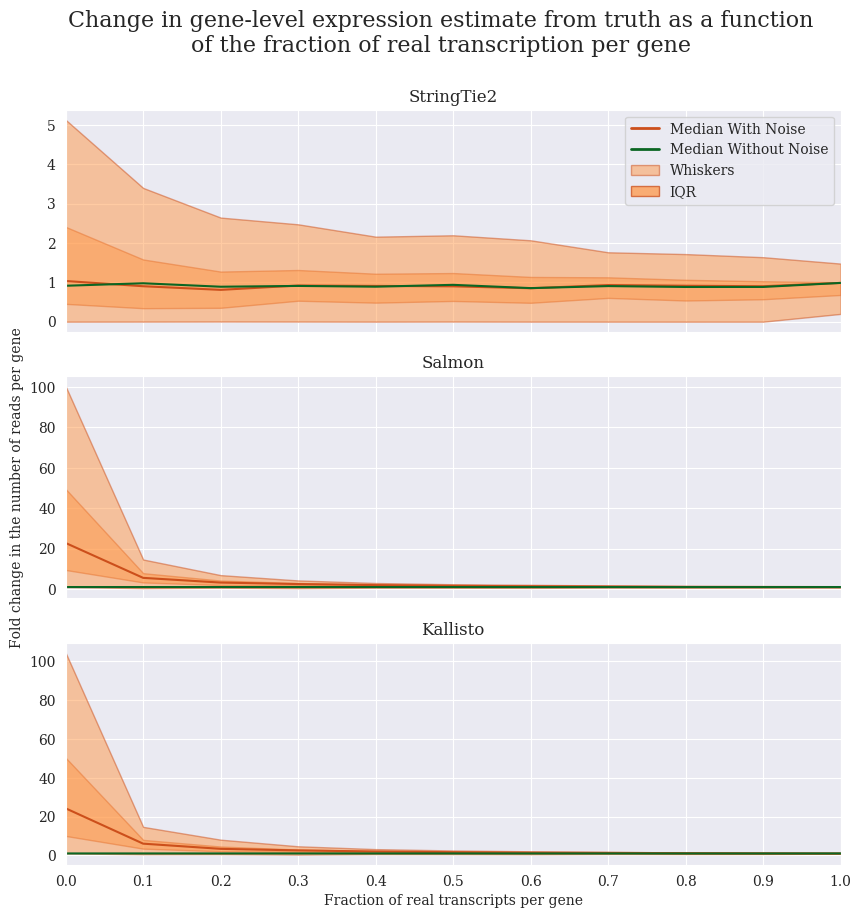

In [167]:
# now we can finally plot everything
fig,axes = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(10,10),dpi=100)

fig.suptitle("Change in gene-level expression estimate from truth as a function\nof the fraction of real transcription per gene", fontsize=16)

axes[0].plot(strg_all_g["frac_real"], strg_all_g["median"],'k',color='#CC4F1B',label="with noise")
axes[0].plot(strg_real_g["frac_real"], strg_real_g["median"],'k',color='#0B6623',label="without noise")
plt.xlim(strg_all_g["frac_real"].min(),strg_all_g["frac_real"].max())
axes[0].set_xticks(strg_all_g["frac_real"])
axes[0].fill_between(strg_all_g["frac_real"], strg_all_g["q25"], strg_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[0].fill_between(strg_all_g["frac_real"], strg_all_g["whiskLow"], strg_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[0].set_title("StringTie2")

axes[1].plot(slmn_all_g["frac_real"], slmn_all_g["median"],'k',color='#CC4F1B')
axes[1].plot(slmn_real_g["frac_real"], slmn_real_g["median"],'k',color='#0B6623')
plt.xlim(slmn_all_g["frac_real"].min(),slmn_all_g["frac_real"].max())
axes[1].set_xticks(slmn_all_g["frac_real"])
axes[1].fill_between(slmn_all_g["frac_real"], slmn_all_g["q25"], slmn_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[1].fill_between(slmn_all_g["frac_real"], slmn_all_g["whiskLow"], slmn_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[1].set_title("Salmon")
axes[1].set_ylabel("Fold change in the number of reads per gene")

axes[2].plot(klst_all_g["frac_real"], klst_all_g["median"],'k',color='#CC4F1B')
axes[2].plot(klst_real_g["frac_real"], klst_real_g["median"],'k',color='#0B6623')
plt.xlim(klst_all_g["frac_real"].min(),klst_all_g["frac_real"].max())
axes[2].set_xticks(klst_all_g["frac_real"])
axes[2].fill_between(klst_all_g["frac_real"], klst_all_g["q25"], klst_all_g["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[2].fill_between(klst_all_g["frac_real"], klst_all_g["whiskLow"], klst_all_g["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
axes[2].set_title("Kallisto")

axes[2].set_xlabel("Fraction of real transcripts per gene")

legend_elements = [Line2D([0], [0], color='#CC4F1B', lw=2, label='Median With Noise'),
                   Line2D([0], [0], color='#0B6623', lw=2, label='Median Without Noise'),
                   Patch(facecolor='#FF9848', edgecolor='#CC4F1B',alpha=0.5,label='Whiskers'),
                   Patch(facecolor='#FF9848', edgecolor='#CC4F1B',alpha=0.75,label='IQR')]
axes[0].legend(handles=legend_elements)